In [2]:
import sys
sys.path.append('/notebook/captcha_break/utils/')
from dataloader import *

import string
characters = string.digits + string.ascii_uppercase
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

# characters = string.digits + string.ascii_uppercase
dataloader = DataLoader('../sample/')
def gen(batch_size= 128,trainMode = True):
    for  g in dataloader.generate(batchSize=batch_size ,trainMode=True):
        X   =  np.stack([cv2.resize(img,(width,height)) for img in g[0]]).transpose(0,2,1,3)
        y =  np.array(g[1])
        yield [X, y]

import time
import pylab as pl
from IPython import display
for i in range(10):
    [X_test, y_test]  = next(gen(1))
    plt.imshow(X_test[0].transpose(1, 0, 2))
    plt.title(''.join([dataloader.remapDict[x] for x in y_test[0]]))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.5)
display.clear_output(wait=True)

<Figure size 640x480 with 1 Axes>

In [3]:
dataloader.imglist[:10]

['hget.jpg',
 'hsaj.jpg',
 'dncb.jpg',
 'dxqo.jpg',
 'kdnk.jpg',
 'sgsn.jpg',
 'qozf.jpg',
 'hhml.jpg',
 'lybh.jpg',
 'nwnq.jpg']

In [4]:
len(dataloader.testset_idx)

5032

In [5]:
for g in gen(trainMode= True,batch_size= 300):
    print(g[0].shape,g[1].shape)
    break

(300, 170, 80, 3) (300, 4)


In [6]:
[ dataloader.remapDict[i] for i in g[1][0] ]

['R', 'J', 'S', 'Q']

In [7]:
try:
    import sklearn
    import cv2
    import captcha
    
except:
    !pip install scikit-learn
    !pip install opencv-python
    !apt update && apt install -y libsm6 libxext6  libxrender1 libxext-dev
    !pip install captcha
    import sklearn
    import cv2
    import captcha
    

import mxnet as mx
import sys
sys.path.append('/notebook/captcha_break/utils/')
from dataloader import *
%matplotlib inline

from mxnet import gluon
import  mxnet.ndarray as nd
from mxnet.gluon import nn
from mxnet import autograd, nd

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
class Captcha(nn.Block):
    # 声明带有模型参数的层，这里我们声明了两个全连接层。
    def __init__(self, cls,**kwargs):
        # 调用 MLP 父类 Block 的构造函数来进行必要的初始化。这样在构造实例时还可以指定
        # 其他函数参数，例如后面章节将介绍的模型参数 params。
        super(Captcha, self).__init__(**kwargs)
        def _getOutput(cls):
            captchaOutput = nn.Sequential()
            captchaOutput.add(nn.Dense(256))
            captchaOutput.add(nn.Dense(128))
            captchaOutput.add(nn.Dense(cls))
            return captchaOutput
        
        with self.name_scope():
            self.feature = nn.Sequential(prefix='feature_')
            with self.feature.name_scope():
                for i in range(4):
                    self.feature.add(nn.Conv2D(32*2**i, kernel_size=3,padding=1, activation='relu'))
                    self.feature.add(nn.Conv2D(32*2**i, kernel_size=3,padding=1, activation='relu'))
                    self.feature.add(nn.MaxPool2D((2,2)))
                self.feature.add(nn.Flatten())
                self.feature.add(nn.Dropout(0.25))
            
            self.output1 =_getOutput(cls)
            self.output2 =_getOutput(cls)
            self.output3 =_getOutput(cls)
            self.output4 =_getOutput(cls) 


    # 定义模型的前向计算，即如何根据输入 x 计算返回所需要的模型输出。
    def forward(self, x):
        x = self.feature(x)
        return self.output1(x) , self.output2(x) , self.output3(x) , self.output4(x) 

In [15]:
net = Captcha(26,prefix = 'captcha_')
# net.initialize(ctx=mx.cpu())
net.load_params('./epoch_395.params',ctx  = mx.gpu(2))

In [82]:
x = nd.array(g[0],ctx = mx.cpu()).transpose([0,3,1,2])[0]
y = net(x_for_predict)

Text(0.5,1,'MHKB')

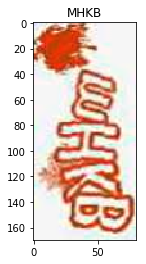

In [107]:
# x = nd.array(g[0],ctx = mx.cpu()).transpose([0,3,1,2])[0]
plt.imshow(g[0][0])
plt.title(''.join([dataloader.remapDict[x] for x in g[1][0]]))

In [104]:
g[0].shape

(10, 170, 80, 3)

In [65]:
predictResult = np.stack([y_predict[i].asnumpy().argmax(1) for i in range(4)]).T
gtResult = g[1]

In [93]:
from mxnet.gluon import loss
floss = loss.SoftmaxCrossEntropyLoss()
batch_size = 10
for g in gen(batch_size,trainMode=True):
    x = nd.array(g[0]).transpose([0,3,1,2])
    x = x.as_in_context(mx.cpu())
    y = nd.array(g[1]).as_in_context(mx.cpu())

#     with autograd.record():
    result = net(x)

    l = floss(result[0], y[:,0]) + \
        floss(result[1], y[:,1]) + \
        floss(result[2], y[:,2]) + \
        floss(result[3], y[:,3]) 
    print(l)


[60.26805  41.83211  83.79496  37.648785 60.293594 39.2728   64.91545
 52.68613  48.06631  54.918262]
<NDArray 10 @cpu(0)>

[27.03398  48.587944 49.83552  32.55587  32.30141  49.862644 38.654617
 51.323734 37.068707 54.00748 ]
<NDArray 10 @cpu(0)>

[46.942482 55.455482 47.05058  61.900555 63.245255 54.135574 55.834583
 36.944794 36.886234 53.044647]
<NDArray 10 @cpu(0)>

[31.932344 50.05921  42.83229  54.482555 26.690777 55.23429  53.832047
 56.272495 72.353455 58.51637 ]
<NDArray 10 @cpu(0)>

[94.182175 61.87609  24.779346 47.30841  46.49844  69.21584  36.59917
 36.23746  30.495262 64.595505]
<NDArray 10 @cpu(0)>

[25.294815 48.302345 51.650658 48.381695 38.954166 82.2435   57.19326
 23.235558 34.96305  28.222858]
<NDArray 10 @cpu(0)>


KeyboardInterrupt: 

In [102]:
x.shape

(3, 170, 80)

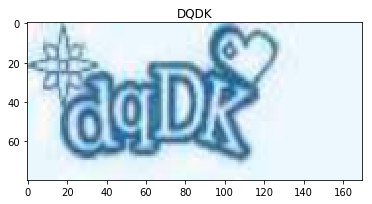

In [16]:
width, height, n_len, n_class = 170, 80, 4, 26+1
batch_size = 256

# characters = string.digits + string.ascii_uppercase
dataloader = DataLoader('../sample/')
def gen(batch_size= 128,trainMode = True):
    for  g in dataloader.generate(batchSize=batch_size ,trainMode=True):
        X   =  np.stack([cv2.resize(img,(width,height)) for img in g[0]])
        y =  np.array(g[1])
        yield [X, y]
    
import time
import pylab as pl
from IPython import display
for i in range(10):
    [X_test, y_test]  = next(gen(1))
    plt.imshow(X_test[0])
    plt.title(''.join([dataloader.remapDict[x] for x in y_test[0]]))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.5)
display.clear_output(wait=True)

In [125]:
for g in gen(trainMode= False,batch_size= 3):
    print(g[0].shape,g[1].shape)
    break

(3, 80, 170, 3) (3, 4)


In [126]:
np.stack([net(nd.array(g[0]).transpose([0,3,1,2]))[i].asnumpy().argmax(1) for i in range(4)]).T


array([[ 2,  1,  0, 19],
       [ 1, 15, 16, 22],
       [19, 12,  6,  0]])

In [127]:
g[1]

array([[ 2,  1,  0, 19],
       [ 1, 15, 16, 22],
       [19, 12,  6,  0]])

# 预测效果展示

## 首先，我们获取三张图片

In [130]:
for g in gen(trainMode= False,batch_size= 3):
    print(g[0].shape,g[1].shape)
    break

(3, 80, 170, 3) (3, 4)


## 对三张图片，我们可以进行预测


img shape and output shape is 
(3, 80, 170, 3) (3, 4)
predict is :
[[19  2 13  3]
 [ 3 23  3 25]
 [ 6 12  0  0]]


real value is :
[[19  2 13  3]
 [ 3 23  3 25]
 [ 6 12  0  0]]
show result


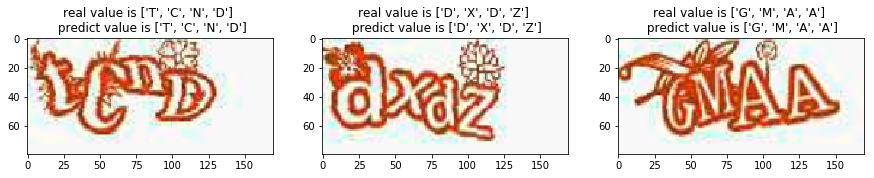

In [156]:
for g in gen(trainMode= False,batch_size= 3):
    print('img shape and output shape is ')
    print(g[0].shape,g[1].shape)
    predict = np.stack([net(nd.array(g[0]).transpose([0,3,1,2]))[i].asnumpy().argmax(1) for i in range(4)]).T
    real = g[1]
    print('predict is :')
    print(predict)
    print('\n')
    print('real value is :')
    print(real)
    
    print('show result')
    plt.rc('figure',figsize = (15,45))
    for  i in range(3):
        
        plt.subplot(1,3,i+1)
        realvalue = [ dataloader.remapDict[v] for v in real[i]]
        predictvalue =[ dataloader.remapDict[v] for v in  predict[i] ]
        plt.title('real value is {} \n predict value is {}'.format(realvalue,predictvalue))
        plt.imshow(g[0][i])
    plt.show()
    
    break


In [157]:
# 统计一发准确率

In [ ]:
count = 0
judgelist = []

for g in gen(trainMode= False,batch_size= 1):

    predict = np.stack([net(nd.array(g[0],ctx = mx.gpu(2)).transpose([0,3,1,2]))[i].asnumpy().argmax(1) for i in range(4)]).T
    real = g[1]
    judge  = np.array_equal(predict,real)
    judgelist.append(judge)
    count +=1
    if count == 5000:
        break
    if count % 200 == 0:
        print(count)


200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000


In [20]:
from collections import Counter

In [21]:
Counter(judgelist)

Counter({True: 987, False: 13})

In [23]:
import torch